# Tarea 4

**Autor:** Alejandro Zarate Macias  
**Curso:** Métodos Matemáticos para Análisis de Datos  
**Fecha:** 15 de Septiembre 2025

---

## Introducción

En este notebook se abordan los problemas 5-9 de la Tarea 4, en los que se requiere la implementacion de algoritmos como BFGS y Gauss-Newton, así como la aplicación de estos a problemas específicos de optimización.

---

# Problema 5

Cree un script en Python que implemente el algoritmo BFGS para las funciones (4)-(6). Utilice condiciones de Wolfe o condiciones de Wolfe fuertes para calcular pasos de longitud adecuados. Utilice diferencias finitas para aproximar los gradientes analíticos de las funciones. Muestre gráficos de las iteraciones en función del valor de la función para mostrar cómo este último disminuye a medida que aumenta el primero.

## Métodos

In [1]:
import numpy as np                  # Para operaciones vectoriales y matriciales
import matplotlib.pyplot as plt     # Para visualización de datos
from typing import Callable         # Para anotaciones de tipos

In [2]:
class BFGS:
    def __init__(self):
        pass
    
    def optimize(self, 
                 func: Callable,  
                 x0: np.ndarray, 
                 max_iterations: int=1000,
                 h: float=1e-5,
                 stop_value: float=None,
                 c1: float=1e-4,
                 c2: float=0.9):
        '''
        Optimización utilizando el algoritmo BFGS.

        Args:
            func (Callable): Función objetivo a minimizar.
            x0 (np.ndarray): Punto inicial para la optimización.
            max_iterations (int): Número máximo de iteraciones.
            h (float): Paso para la aproximación numérica del gradiente.
            stop_value (float): Valor de la función para detener la optimización si se alcanza.
            c1 (float): Parámetro para la condición de Armijo.
            c2 (float): Parámetro para la condición de curvatura.

        Returns:
            x (np.ndarray): Punto óptimo encontrado.
            trajectory (list): Valores de la función en cada iteración.
        '''
        x = np.array(x0, dtype=float)
        n = len(x)
        H_inv = np.eye(n)
        trajectory = []
        
        # iteramos hasta el valor de max_iterations
        for iteration in range(max_iterations):
            f_val = func(x)
            trajectory.append(f_val)

            # Verificamos si el stop_value ha sido alcanzado
            if stop_value and f_val <= stop_value:
                print(f"Stopping criterion reached at iteration {iteration}")
                break
            
            # Gradiente numérico
            grad = self.numerical_gradient(func, x, h=h)
            # Dirección de descenso
            p = -H_inv @ grad 
            # Búsqueda de línea con condiciones de Wolfe
            alpha = self.wolfe_line_search(func, x, p, grad, c1=c1, c2=c2, h=h)
            
            # Actualización del punto
            x_new = x + alpha * p
            grad_new = self.numerical_gradient(func, x_new, h=h)

            s = x_new - x
            y = grad_new - grad

            # Actualización de la aproximación de la inversa de la Hessiana
            if np.dot(y, s) > 1e-10:
                rho = 1.0 / np.dot(y, s)
                I = np.eye(n)
                H_inv = (I - rho * np.outer(s, y)) @ H_inv @ (I - rho * np.outer(y, s)) + rho * np.outer(s, s)
            
            # Actualizamos x
            x = x_new
            
        return x, trajectory
    
    def wolfe_line_search(self, 
                          func: Callable, 
                          x: np.ndarray, 
                          p: np.ndarray, 
                          grad: np.ndarray, 
                          c1: float=1e-4, 
                          c2: float=0.9, 
                          h: float=1e-5, 
                          alpha_init: float=1.0, 
                          max_iter: int=50):
        '''
        Búsqueda de línea que satisface las condiciones de Wolfe.
        
        Args:
            func (Callable): Función objetivo.
            x (np.ndarray): Punto actual.
            p (np.ndarray): Dirección de búsqueda.
            grad (np.ndarray): Gradiente en el punto actual.
            c1 (float): Parámetro para la condición de Armijo.
            c2 (float): Parámetro para la condición de curvatura.
            h (float): Paso para la aproximación numérica del gradiente.
            alpha_init (float): Valor inicial para el tamaño del paso.
            max_iter (int): Número máximo de iteraciones para la búsqueda de línea.
            
        Returns:
            alpha (float): Tamaño del paso que satisface las condiciones de Wolfe.
        '''
        alpha = alpha_init
        f_x = func(x)
        grad_p = np.dot(grad, p)
        
        # Si la dirección no es de descenso, retornamos un paso muy pequeño
        if grad_p >= 0:
            return 1e-8

        # Busqueda de línea
        for i in range(max_iter):
            # Nuevo punto y evaluación de la función
            x_new = x + alpha * p
            f_new = func(x_new)

            # Condición de Armijo
            armijo_condition = f_new <= f_x + c1 * alpha * grad_p

            # Condición de curvatura
            if armijo_condition:
                grad_new = self.numerical_gradient(func, x_new, h=h)
                grad_new_p = np.dot(grad_new, p)
                
                curvature_condition = grad_new_p >= c2 * grad_p
                
                # Si ambas condiciones se cumplen, retornamos alpha
                if curvature_condition:
                    return alpha
                # Si la condición de curvatura no se cumple, aumentamos alpha
                else:
                    alpha *= 2.0
            # Si la condición de Armijo no se cumple, disminuimos alpha
            else:
                alpha *= 0.5

            # Evitamos que alpha sea demasiado pequeño
            if alpha < 1e-10:
                return 1e-10
                
        return alpha

    def numerical_gradient(self, f: Callable, x: np.ndarray, h: float=1e-5):
        '''
        Aproximación numérica del gradiente usando diferencias centrales.
        
        Args:
            f (Callable): Función objetivo.
            x (np.ndarray): Punto en el que se evalúa el gradiente.
            h (float): Paso para la aproximación.

        Returns:
            grad (np.ndarray): Gradiente aproximado en el punto x.
        '''
        n = len(x)
        grad = np.zeros(n)
        
        for i in range(n):
            x_plus = x.copy()
            x_minus = x.copy()
            
            x_plus[i] += h
            x_minus[i] -= h

            # Diferencia central
            grad[i] = (f(x_plus) - f(x_minus)) / (2*h)

        return grad

    def plot(self, trajectory, title="BFGS"):
        '''
        Función para graficar la trayectoria de optimización.

        Args:
            trajectory (list): Valores de la función en cada iteración.
            title (str): Título de la gráfica.

        Returns:
            None, solo muestra la gráfica.
        '''
        plt.figure(figsize=(8, 6))
        plt.plot(trajectory)
        plt.title(title)
        plt.xlabel('Iteraciones')
        plt.ylabel('Valor de la función')
        plt.grid(True)
        plt.show()

In [3]:
# (4) Funcion de esfera trasladada
def translated_sphere(x):
    c = np.ones(len(x))
    return np.sum((x - c)**2)

# (5) Funcion de Rosenbrock
def rosenbrock(x):
    result = 0
    for i in range(len(x) - 1):
        result += 100 * (x[i+1] - x[i]**2)**2 + (1 - x[i])**2
    return result

# (6) Funcion de perm
def perm(x):
    B = 1
    result = 0
    for k in range(1, len(x) + 1):
        inner_sum = 0
        for i in range(1, len(x) + 1):
            inner_sum += (i + B) * (x[i-1]**k - (1/i)**k)
        result += inner_sum**2
    return result 

## Resultados

In [4]:
# Valores de prueba
# x0 = [0.5, 0.5, 0.5, 0.5, 0.5]
n = 5
x0 = [0.5] * n

# Crear instancia del optimizador BFGS
bfgs_algorithm = BFGS()

Stopping criterion reached at iteration 1
FUNCIÓN ESFERA TRASLADADA
Valor óptimo encontrado: [1. 1. 1. 1. 1.]
Valor de la función en el óptimo: 5.364784270031189e-23
Número de iteraciones: 2

Gráfica Descenso de la función:


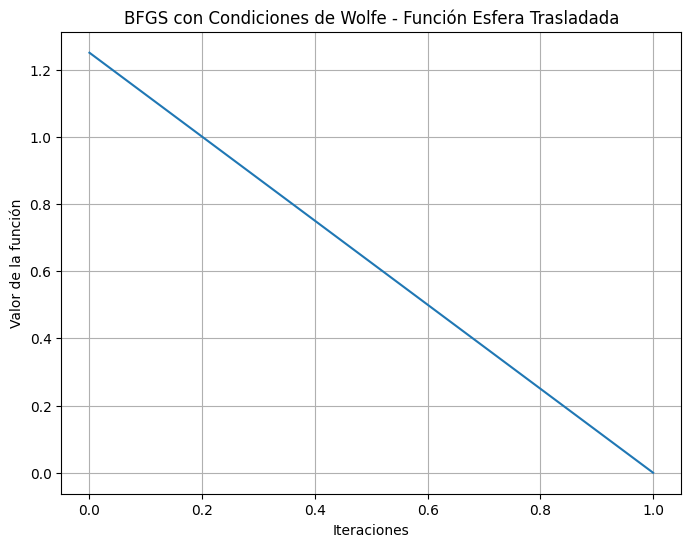

In [5]:
x_sphere, trajectory_sphere = bfgs_algorithm.optimize(
    func=translated_sphere,
    x0=x0,
    h=1e-5,
    max_iterations=1000,
    stop_value=1e-2
)
print("="*60)
print("FUNCIÓN ESFERA TRASLADADA")
print("="*60)
print("Valor óptimo encontrado:", x_sphere)
print("Valor de la función en el óptimo:", translated_sphere(x_sphere))
print("Número de iteraciones:", len(trajectory_sphere))
print("\nGráfica Descenso de la función:")
bfgs_algorithm.plot(trajectory=trajectory_sphere, title="BFGS con Condiciones de Wolfe - Función Esfera Trasladada")

Stopping criterion reached at iteration 19
FUNCIÓN ROSENBROCK
Valor óptimo encontrado: [0.99258955 0.98507864 0.97017093 0.94051482 0.88124634]
Valor de la función en el óptimo: 0.005867406182907281
Número de iteraciones: 20

Gráfica Descenso de la función:


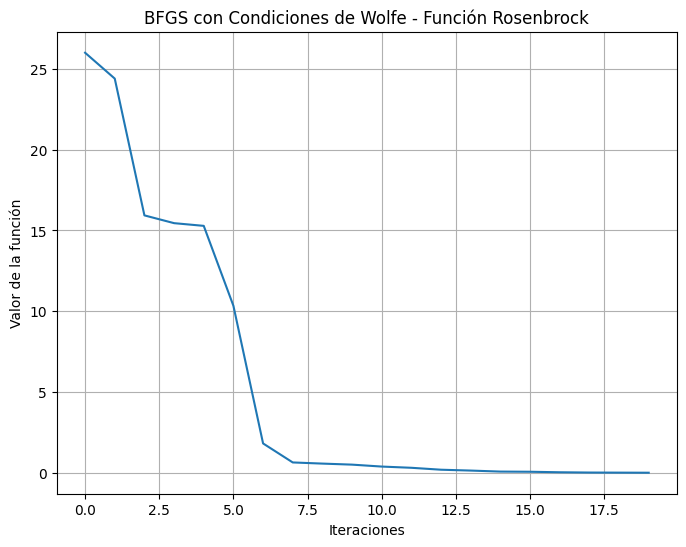

In [6]:
x_rosenbrock, trajectory_rosenbrock = bfgs_algorithm.optimize(
    func=rosenbrock,
    x0=x0,
    h=1e-5,
    max_iterations=1000,
    stop_value=1e-2
)
print("="*60)
print("FUNCIÓN ROSENBROCK")
print("="*60)
print("Valor óptimo encontrado:", x_rosenbrock)
print("Valor de la función en el óptimo:", rosenbrock(x_rosenbrock))
print("Número de iteraciones:", len(trajectory_rosenbrock))
print("\nGráfica Descenso de la función:")
bfgs_algorithm.plot(trajectory=trajectory_rosenbrock, title="BFGS con Condiciones de Wolfe - Función Rosenbrock")

Stopping criterion reached at iteration 10
FUNCIÓN PERM
Valor óptimo encontrado: [0.99722043 0.44473032 0.44108618 0.159346   0.21711688]
Valor de la función en el óptimo: 0.009839381866224833
Número de iteraciones: 11

Gráfica Descenso de la función:


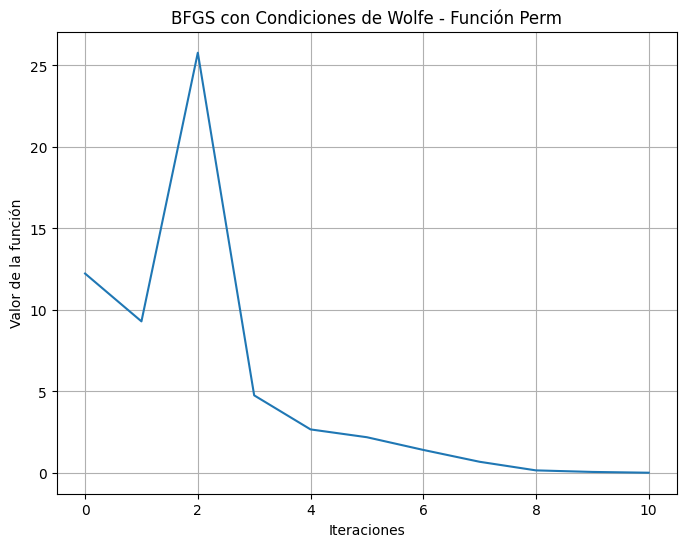

In [7]:
x_perm, trajectory_perm = bfgs_algorithm.optimize(
    func=perm,
    x0=x0,
    h=1e-5,
    max_iterations=1000,
    stop_value=1e-2
)
print("="*60)
print("FUNCIÓN PERM")
print("="*60)
print("Valor óptimo encontrado:", x_perm)
print("Valor de la función en el óptimo:", perm(x_perm))
print("Número de iteraciones:", len(trajectory_perm))
print("\nGráfica Descenso de la función:")
bfgs_algorithm.plot(trajectory=trajectory_perm, title="BFGS con Condiciones de Wolfe - Función Perm")

# Problema 6

Considere la función (5). Resuelva el problema de optimización asociado utilizando los métodos de Newton, SD y BFGS. Para todos estos algoritmos, puede utilizar gradientes numéricos o analíticos. Además, tanto para SD como para BFGS, considere las condiciones de Wolfe o las condiciones de Wolfe fuertes. Muestre los valores de la función para el mismo número de iteraciones mediante una tabla o una figura. La idea es mostrar la comparación de las tasas de convergencia lineal, superlineal y cuadrática.


## Métodos


In [8]:
import numpy as np                  # Para operaciones vectoriales y matriciales
import matplotlib.pyplot as plt     # Para visualización de datos
import pandas as pd                 # Para uso de tablas 
from typing import Callable         # Para anotaciones de tipos

In [9]:
class SteepestDescentWolfe:
    def __init__(self):
        pass
    
    def optimize(self, 
                 func: Callable,  
                 x0: np.ndarray, 
                 max_iterations: int = 1000,
                 h: float = 1e-5,
                 stop_value: float = None,
                 c1: float = 1e-4,
                 c2: float = 0.9):
        ''' 
        Optimización utilizando el método del descenso por el gradiente con condiciones de Wolfe.

        Args:
            func (Callable): Función objetivo a minimizar.
            x0 (np.ndarray): Punto inicial para la optimización.
            max_iterations (int): Número máximo de iteraciones.
            h (float): Paso para la aproximación numérica del gradiente.
            stop_value (float): Valor de la función para detener la optimización si se alcanza.
            c1 (float): Parámetro para la condición de Armijo.
            c2 (float): Parámetro para la condición de curvatura.

        Returns:
            x (np.ndarray): Punto óptimo encontrado.
            trajectory (list): Valores de la función en cada iteración.
        '''
        x = np.array(x0, dtype=float)
        trajectory = []
        
        # iteramos hasta el valor de max_iterations
        for iteration in range(max_iterations):
            f_val = func(x)
            trajectory.append(f_val)

            # Verificamos si el stop_value ha sido alcanzado
            if stop_value and f_val <= stop_value:
                print(f"Stopping criterion reached at iteration {iteration}")
                break

            # Gradiente numérico
            grad = self.numerical_gradient(func, x, h=h)
            p = -grad
            
            # Búsqueda de línea con condiciones de Wolfe
            alpha = self.wolfe_line_search(func, x, p, grad, c1=c1, c2=c2, h=h)
            
            # Actualizamos x
            x = x + alpha * p
            
        return x, trajectory

    def numerical_gradient(self, f: Callable, x: np.ndarray, h: float=1e-5):
        '''
        Calcula el gradiente numérico de una función en un punto dado.

        Args:
            f (Callable): Función objetivo.
            x (np.ndarray): Punto en el que se evalúa el gradiente.
            h (float): Paso para la aproximación numérica.

        Returns:
            grad (np.ndarray): Gradiente de la función en el punto x.
        '''
        n = len(x)
        grad = np.zeros(n)
        
        for i in range(n):
            x_plus = x.copy()
            x_minus = x.copy()
            
            x_plus[i] += h
            x_minus[i] -= h
            
            # Diferencia central
            grad[i] = (f(x_plus) - f(x_minus)) / (2*h)

        return grad
    
    def wolfe_line_search(self, 
                          func: Callable, 
                          x: np.ndarray, 
                          p: np.ndarray, 
                          grad: np.ndarray, 
                          c1: float=1e-4, 
                          c2: float=0.9, 
                          h: float=1e-5, 
                          alpha_init: float=1.0, 
                          max_iter: int=50):
        alpha = alpha_init
        f_x = func(x)
        grad_p = np.dot(grad, p)

        # Si la dirección no es de descenso, retornamos un paso muy pequeño
        if grad_p >= 0:
            return 1e-8
        
        # Búsqueda de línea
        for i in range(max_iter):
            x_new = x + alpha * p
            f_new = func(x_new)

            # Condición de Armijo
            armijo_condition = f_new <= f_x + c1 * alpha * grad_p
            
            # Condición de curvatura
            if armijo_condition:
                grad_new = self.numerical_gradient(func, x_new, h=h)
                grad_new_p = np.dot(grad_new, p)
                
                curvature_condition = grad_new_p >= c2 * grad_p
                
                # Si ambas condiciones se cumplen, retornamos alpha
                if curvature_condition:
                    return alpha
                # Si la condición de curvatura no se cumple, aumentamos alpha
                else:
                    alpha *= 2.0
            # Si la condición de Armijo no se cumple, disminuimos alpha
            else:
                alpha *= 0.5

            # Evitamos que alpha sea demasiado pequeño
            if alpha < 1e-10:
                return 1e-10

        return alpha
    
    def plot(self, trajectory, title="Steepest Descent"):
        '''
        Función para graficar la trayectoria de optimización.

        Args:
            trajectory (list): Valores de la función en cada iteración.
            title (str): Título de la gráfica.
            
        Returns:
            None, solo muestra la gráfica.
        '''
        plt.figure(figsize=(8, 6))
        plt.plot(trajectory)
        plt.title(title)
        plt.xlabel('Iteraciones')
        plt.ylabel('Valor de la función')
        plt.grid(True)
        plt.show()

In [10]:
class BFGS:
    def __init__(self):
        pass
    
    def optimize(self, 
                 func: Callable,  
                 x0: np.ndarray, 
                 max_iterations: int = 1000,
                 h: float = 1e-5,
                 stop_value: float = None,
                 c1: float = 1e-4,
                 c2: float = 0.9):
        ''' 
        Optimización utilizando el algoritmo BFGS.
        Args:
            func (Callable): Función objetivo a minimizar.
            x0 (np.ndarray): Punto inicial para la optimización.
            max_iterations (int): Número máximo de iteraciones.
            h (float): Paso para la aproximación numérica del gradiente.
            stop_value (float): Valor de la función para detener la optimización si se alcanza.
            c1 (float): Parámetro para la condición de Armijo.
            c2 (float): Parámetro para la condición de curvatura.
        '''
        x = np.array(x0, dtype=float)
        n = len(x)
        H_inv = np.eye(n)
        trajectory = []
        
        # iteramos hasta el valor de max_iterations
        for iteration in range(max_iterations):
            f_val = func(x)
            trajectory.append(f_val)

            # Verificamos si el stop_value ha sido alcanzado
            if stop_value and f_val <= stop_value:
                print(f"Stopping criterion reached at iteration {iteration}")
                break

            # Gradiente numérico
            grad = self.numerical_gradient(func, x, h=h)

            # Dirección de descenso
            p = -H_inv @ grad 

            # Búsqueda de línea con condiciones de Wolfe
            alpha = self.wolfe_line_search(func, x, p, grad, c1=c1, c2=c2, h=h)

            # Actualización del punto
            x_new = x + alpha * p
            grad_new = self.numerical_gradient(func, x_new, h=h)

            s = x_new - x
            y = grad_new - grad

            # Actualización de la aproximación de la inversa de la Hessiana
            if np.dot(y, s) > 1e-10:
                rho = 1.0 / np.dot(y, s)
                I = np.eye(n)
                H_inv = (I - rho * np.outer(s, y)) @ H_inv @ (I - rho * np.outer(y, s)) + rho * np.outer(s, s)
            
            # Actualizamos x
            x = x_new
            
        return x, trajectory
    
    def wolfe_line_search(self, 
                          func: Callable, 
                          x: np.ndarray, 
                          p: np.ndarray, 
                          grad: np.ndarray, 
                          c1: float = 1e-4, 
                          c2: float = 0.9, 
                          h: float = 1e-5, 
                          alpha_init: float = 1.0, 
                          max_iter: int = 50):
        """
        Búsqueda de línea que satisface las condiciones de Wolfe.

        Args:
            func (Callable): Función objetivo.
            x (np.ndarray): Punto actual.
            p (np.ndarray): Dirección de búsqueda.
            grad (np.ndarray): Gradiente en el punto actual.
            c1 (float): Parámetro para la condición de Armijo.
            c2 (float): Parámetro para la condición de curvatura.
            h (float): Paso para la aproximación numérica del gradiente.
            alpha_init (float): Valor inicial para el tamaño del paso.
            max_iter (int): Número máximo de iteraciones para la búsqueda de línea.

        Returns:
            alpha (float): Tamaño del paso que satisface las condiciones de Wolfe.
        """
        alpha = alpha_init
        f_x = func(x)
        grad_p = np.dot(grad, p)

        # Si la dirección no es de descenso, retornamos un paso muy pequeño
        if grad_p >= 0:
            return 1e-8
        
        for i in range(max_iter):
            x_new = x + alpha * p
            f_new = func(x_new)

            # Condición de Armijo
            armijo_condition = f_new <= f_x + c1 * alpha * grad_p
            
            # Condición de curvatura
            if armijo_condition:
                grad_new = self.numerical_gradient(func, x_new, h=h)
                grad_new_p = np.dot(grad_new, p)

                curvature_condition = grad_new_p >= c2 * grad_p
                
                # Si ambas condiciones se cumplen, retornamos alpha
                if curvature_condition:
                    return alpha
                # Si la condición de curvatura no se cumple, aumentamos alpha
                else:
                    alpha *= 2.0
            # Si la condición de Armijo no se cumple, disminuimos alpha
            else:
                alpha *= 0.5

            # Evitamos que alpha sea demasiado pequeño
            if alpha < 1e-10:
                return 1e-10
                
        return alpha

    def numerical_gradient(self, f: Callable, x: np.ndarray, h: float) -> np.ndarray:
        '''
        Calcula el gradiente numérico de una función en un punto dado.

        Args:
            f (Callable): Función objetivo.
            x (np.ndarray): Punto en el que se evalúa el gradiente.
            h (float): Paso para la aproximación numérica.

        Returns:
            grad (np.ndarray): Gradiente de la función en el punto x.
        '''
        n = len(x)
        grad = np.zeros(n)
        
        for i in range(n):
            x_plus = x.copy()
            x_minus = x.copy()
            
            x_plus[i] += h
            x_minus[i] -= h
            
            # Diferencia central
            grad[i] = (f(x_plus) - f(x_minus)) / (2*h)

        return grad

    def plot(self, trajectory, title="BFGS"):
        '''
        Plotea la trayectoria de la optimización.

        Args:
            trajectory (list): Lista con los valores de la función en cada iteración.
            title (str): Título del gráfico.

        Returns:
            None, solo muestra la gráfica.
        '''
        plt.figure(figsize=(8, 6))
        plt.plot(trajectory)
        plt.title(title)
        plt.xlabel('Iteraciones')
        plt.ylabel('Valor de la función')
        plt.grid(True)
        plt.show()

In [11]:
class Newton:
    def __init__(self):
        pass
    
    def optimize(self, 
                 func: Callable,  
                 x0: np.ndarray, 
                 max_iterations: int = 1000,
                 h: float = 1e-5,
                 stop_value: float = None,
                 tolerance: float = 1e-8,
                 c1: float = 1e-4,
                 c2: float = 0.9):
        '''
        Optimización utilizando el método de Newton.

        Args:
            func (Callable): Función objetivo a minimizar.
            x0 (np.ndarray): Punto inicial para la optimización.
            max_iterations (int): Número máximo de iteraciones.
            h (float): Paso para la aproximación numérica del gradiente y Hessiana.
            stop_value (float): Valor de la función para detener la optimización si se alcanza.
            tolerance (float): Tolerancia para la convergencia del gradiente.
            c1 (float): Parámetro para la condición de Armijo.
            c2 (float): Parámetro para la condición de curvatura.

        Returns:
            x (np.ndarray): Punto óptimo encontrado.
            trajectory (list): Valores de la función en cada iteración.
        '''
        x = np.array(x0, dtype=float)
        n = len(x)
        trajectory = []
        
        # iteramos hasta el valor de max_iterations
        for iteration in range(max_iterations):
            f_val = func(x)
            trajectory.append(f_val)

            # Verificamos si el stop_value ha sido alcanzado
            if stop_value and f_val <= stop_value:
                print(f"Stopping criterion reached at iteration {iteration}")
                break

            # Gradiente numérico
            grad = self.numerical_gradient(func, x, h=h)
            grad_norm = np.linalg.norm(grad)
            
            # Verificamos la convergencia del gradiente
            if grad_norm < tolerance:
                print(f"Gradient convergence achieved at iteration {iteration}")
                break
            
            # Hessiana numérica
            hessian = self.numerical_hessian(func, x, h=h)
            
            # Resolver H * p = -grad
            try:
                p = np.linalg.solve(hessian, -grad)
            except np.linalg.LinAlgError:
                print(f"Singular Hessian at iteration {iteration}, using regularization")
                regularization = 1e-6 * np.eye(n)
                p = np.linalg.solve(hessian + regularization, -grad)
            
            # Si p no es una dirección de descenso, usamos el negativo del gradiente
            if np.dot(grad, p) >= 0:
                print(f"Not a descent direction at iteration {iteration}, using negative gradient")
                p = -grad
            
            # Búsqueda de línea con condiciones de Wolfe
            alpha = self.wolfe_line_search(func, x, p, grad, c1=c1, c2=c2, h=h)

            # Actualizamos x
            x = x + alpha * p
            
        return x, trajectory

    def numerical_gradient(self, f: Callable, x: np.ndarray, h: float) -> np.ndarray:
        '''
        Aproximación numérica del gradiente usando diferencias centrales.
        
        Args:
            f (Callable): Función objetivo.
            x (np.ndarray): Punto en el que se evalúa el gradiente.
            h (float): Paso para la aproximación.

        Returns:
            grad (np.ndarray): Gradiente aproximado en el punto x.
        '''
        n = len(x)
        grad = np.zeros(n)
        
        for i in range(n):
            x_plus = x.copy()
            x_minus = x.copy()
            
            x_plus[i] += h
            x_minus[i] -= h
            
            # Diferencia central
            grad[i] = (f(x_plus) - f(x_minus)) / (2*h)

        return grad

    def numerical_hessian(self, f: Callable, x: np.ndarray, h: float) -> np.ndarray:
        '''
        Aproximación numérica de la matriz Hessiana usando diferencias finitas.
        
        Args:
            f (Callable): Función objetivo.
            x (np.ndarray): Punto en el que se evalúa la Hessiana.
            h (float): Paso para la aproximación.

        Returns:
            hessian (np.ndarray): Matriz Hessiana aproximada en el punto x.
        '''
        n = len(x)
        hessian = np.zeros((n, n))
        
        # Elementos de la diagonal (segundas derivadas parciales)
        for i in range(n):
            x_plus = x.copy()
            x_minus = x.copy()
            x_plus[i] += h
            x_minus[i] -= h
            
            hessian[i, i] = (f(x_plus) - 2*f(x) + f(x_minus)) / (h**2)
        
        # Elementos fuera de la diagonal (derivadas cruzadas)
        for i in range(n):
            for j in range(i+1, n):
                x_pp = x.copy()
                x_pm = x.copy()
                x_mp = x.copy()
                x_mm = x.copy()
                
                x_pp[i] += h
                x_pp[j] += h
                
                x_pm[i] += h
                x_pm[j] -= h
                
                x_mp[i] -= h
                x_mp[j] += h
                
                x_mm[i] -= h
                x_mm[j] -= h
                
                hessian[i, j] = (f(x_pp) - f(x_pm) - f(x_mp) + f(x_mm)) / (4 * h**2)
                hessian[j, i] = hessian[i, j]  # Simetría de la Hessiana
        
        return hessian
    
    def wolfe_line_search(self, 
                          func: Callable, 
                          x: np.ndarray, 
                          p: np.ndarray, 
                          grad: np.ndarray, 
                          c1: float = 1e-4, 
                          c2: float = 0.9, 
                          h: float = 1e-5, 
                          alpha_init: float = 1.0, 
                          max_iter: int = 50):
        '''
        Búsqueda de línea que satisface las condiciones de Wolfe.
        
        Args:
            func (Callable): Función objetivo.
            x (np.ndarray): Punto actual.
            p (np.ndarray): Dirección de búsqueda.
            grad (np.ndarray): Gradiente en el punto actual.
            c1 (float): Parámetro para la condición de Armijo.
            c2 (float): Parámetro para la condición de curvatura.
            h (float): Paso para la aproximación numérica del gradiente.
            alpha_init (float): Valor inicial para el tamaño del paso.
            max_iter (int): Número máximo de iteraciones para la búsqueda de línea.
            
        Returns:
            alpha (float): Tamaño del paso que satisface las condiciones de Wolfe.
        '''
        alpha = alpha_init
        f_x = func(x)
        grad_p = np.dot(grad, p)

        # Si la dirección no es de descenso, retornamos un paso muy pequeño
        if grad_p >= 0:
            return 1e-8
        
        # Búsqueda de línea
        for i in range(max_iter):
            x_new = x + alpha * p
            f_new = func(x_new)

            # Condición de Armijo
            armijo_condition = f_new <= f_x + c1 * alpha * grad_p
            
            # Condición de curvatura
            if armijo_condition:
                grad_new = self.numerical_gradient(func, x_new, h=h)
                grad_new_p = np.dot(grad_new, p)

                curvature_condition = grad_new_p >= c2 * grad_p
                
                # Si ambas condiciones se cumplen, retornamos alpha
                if curvature_condition:
                    return alpha
                # Si la condición de curvatura no se cumple, aumentamos alpha
                else:
                    alpha *= 2.0
            # Si la condición de Armijo no se cumple, disminuimos alpha
            else:
                alpha *= 0.5
                
            # Evitamos que alpha sea demasiado pequeño
            if alpha < 1e-10:
                return 1e-10
                
        return alpha
    
    def plot(self, trajectory, title="Newton"):
        '''
        Función para graficar la trayectoria de optimización.

        Args:
            trajectory (list): Valores de la función en cada iteración.
            title (str): Título de la gráfica.

        Returns:
            None, solo muestra la gráfica.
        '''
        plt.figure(figsize=(8, 6))
        plt.plot(trajectory)
        plt.title(title)
        plt.xlabel('Iteraciones')
        plt.ylabel('Valor de la función')
        plt.grid(True)
        plt.show()

## Resultados

In [12]:
# (5) Funcion de Rosenbrock
def rosenbrock(x):
    result = 0
    for i in range(len(x) - 1):
        result += 100 * (x[i+1] - x[i]**2)**2 + (1 - x[i])**2
    return result

In [13]:
# Valores de prueba
# x0 = [0.5, 0.5, 0.5, 0.5, 0.5]
n = 5
x0 = [0.5] * n

# Instancias del algoritmo
sd_algorithm = SteepestDescentWolfe()
bfgs_algorithm = BFGS()
newton_algorithm = Newton()

# Almacenar resultados para comparación
x_values = []
trajectories = []
function_values = []

FUNCIÓN ROSENBROCK
Valor óptimo encontrado: [0.98163202 0.9637258  0.92834617 0.8616938  0.74166391]
Valor de la función en el óptimo: 0.02600977389485091
Número de iteraciones: 1000

Gráfica Descenso de la función:


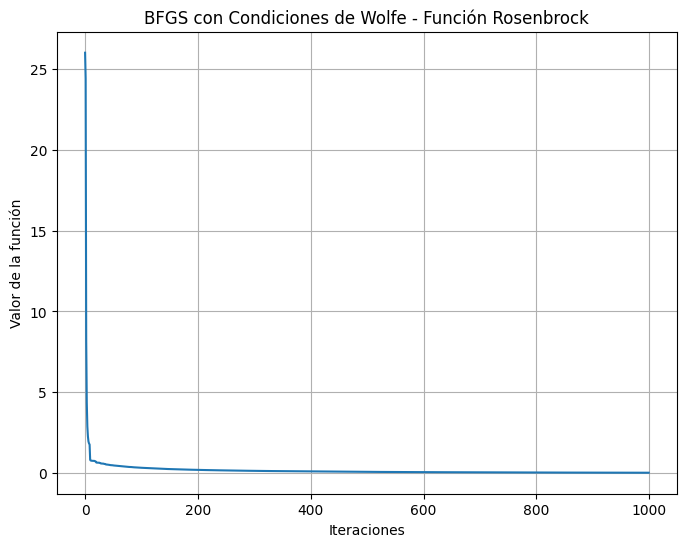

In [14]:
x_rosenbrock, trajectory_rosenbrock = sd_algorithm.optimize(
    func=rosenbrock,
    x0=x0,
    h=1e-5,
    max_iterations=1000,
    stop_value=1e-2
)
x_values.append(x_rosenbrock)
trajectories.append(trajectory_rosenbrock)
function_values.append(rosenbrock(x_rosenbrock))

print("="*60)
print("FUNCIÓN ROSENBROCK")
print("="*60)
print("Valor óptimo encontrado:", x_rosenbrock)
print("Valor de la función en el óptimo:", rosenbrock(x_rosenbrock))
print("Número de iteraciones:", len(trajectory_rosenbrock))
print("\nGráfica Descenso de la función:")
sd_algorithm.plot(trajectory=trajectory_rosenbrock, title="BFGS con Condiciones de Wolfe - Función Rosenbrock")

Stopping criterion reached at iteration 19
FUNCIÓN ROSENBROCK
Valor óptimo encontrado: [0.99258955 0.98507864 0.97017093 0.94051482 0.88124634]
Valor de la función en el óptimo: 0.005867406182907281
Número de iteraciones: 20

Gráfica Descenso de la función:


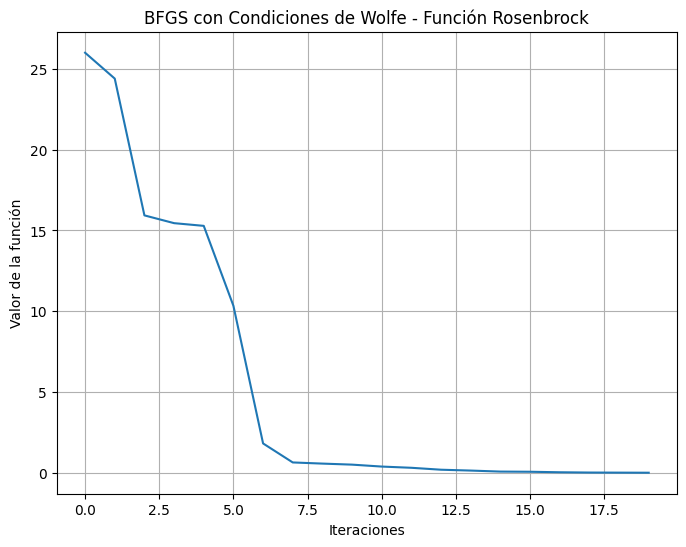

In [15]:
x_rosenbrock, trajectory_rosenbrock = bfgs_algorithm.optimize(
    func=rosenbrock,
    x0=x0,
    h=1e-5,
    max_iterations=1000,
    stop_value=1e-2
)
x_values.append(x_rosenbrock)
trajectories.append(trajectory_rosenbrock)
function_values.append(rosenbrock(x_rosenbrock))

print("="*60)
print("FUNCIÓN ROSENBROCK")
print("="*60)
print("Valor óptimo encontrado:", x_rosenbrock)
print("Valor de la función en el óptimo:", rosenbrock(x_rosenbrock))
print("Número de iteraciones:", len(trajectory_rosenbrock))
print("\nGráfica Descenso de la función:")
bfgs_algorithm.plot(trajectory=trajectory_rosenbrock, title="BFGS con Condiciones de Wolfe - Función Rosenbrock")

Stopping criterion reached at iteration 10
FUNCIÓN ROSENBROCK
Valor óptimo encontrado: [0.99555887 0.99110731 0.9822068  0.96449176 0.9295493 ]
Valor de la función en el óptimo: 0.0017310790386750805
Número de iteraciones: 11

Gráfica Descenso de la función:


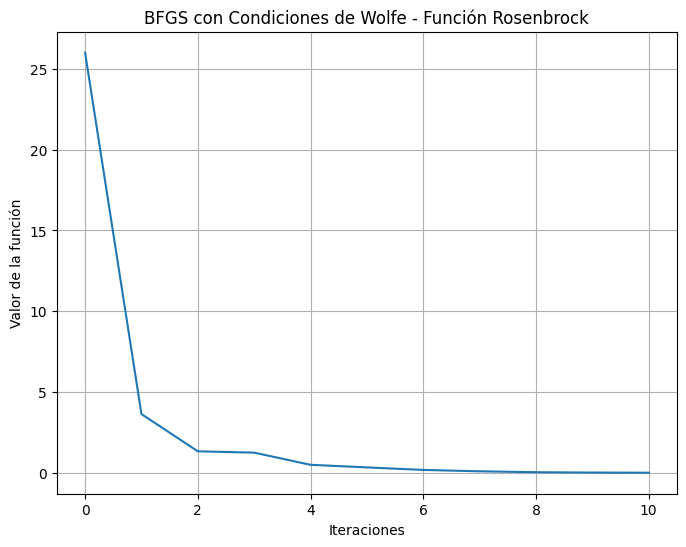

In [16]:
x_rosenbrock, trajectory_rosenbrock = newton_algorithm.optimize(
    func=rosenbrock,
    x0=x0,
    h=1e-5,
    max_iterations=1000,
    stop_value=1e-2
)
x_values.append(x_rosenbrock)
trajectories.append(trajectory_rosenbrock)
function_values.append(rosenbrock(x_rosenbrock))

print("="*60)
print("FUNCIÓN ROSENBROCK")
print("="*60)
print("Valor óptimo encontrado:", x_rosenbrock)
print("Valor de la función en el óptimo:", rosenbrock(x_rosenbrock))
print("Número de iteraciones:", len(trajectory_rosenbrock))
print("\nGráfica Descenso de la función:")
newton_algorithm.plot(trajectory=trajectory_rosenbrock, title="BFGS con Condiciones de Wolfe - Función Rosenbrock")

In [17]:
# Crear tabla comparativa de resultados
algorithms = ['Steepest Descent', 'BFGS', 'Newton']
results_df = pd.DataFrame({
    'Algoritmo': algorithms,
    'Valor de la Función': function_values,
    'Número de Iteraciones': [len(traj) for traj in trajectories],
    'Convergencia': ['Lineal', 'Superlineal', 'Cuadrática']
})

# Configurar formato para mejor visualización
pd.set_option('display.float_format', '{:.6f}'.format)

print("TABLA COMPARATIVA DE RESULTADOS - FUNCIÓN ROSENBROCK")
display(results_df)


TABLA COMPARATIVA DE RESULTADOS - FUNCIÓN ROSENBROCK


,Algoritmo,Valor de la Función,Número de Iteraciones,Convergencia
0,Steepest Descent,0.026010,1000,Lineal
1,BFGS,0.005867,20,Superlineal
2,Newton,0.001731,11,Cuadrática


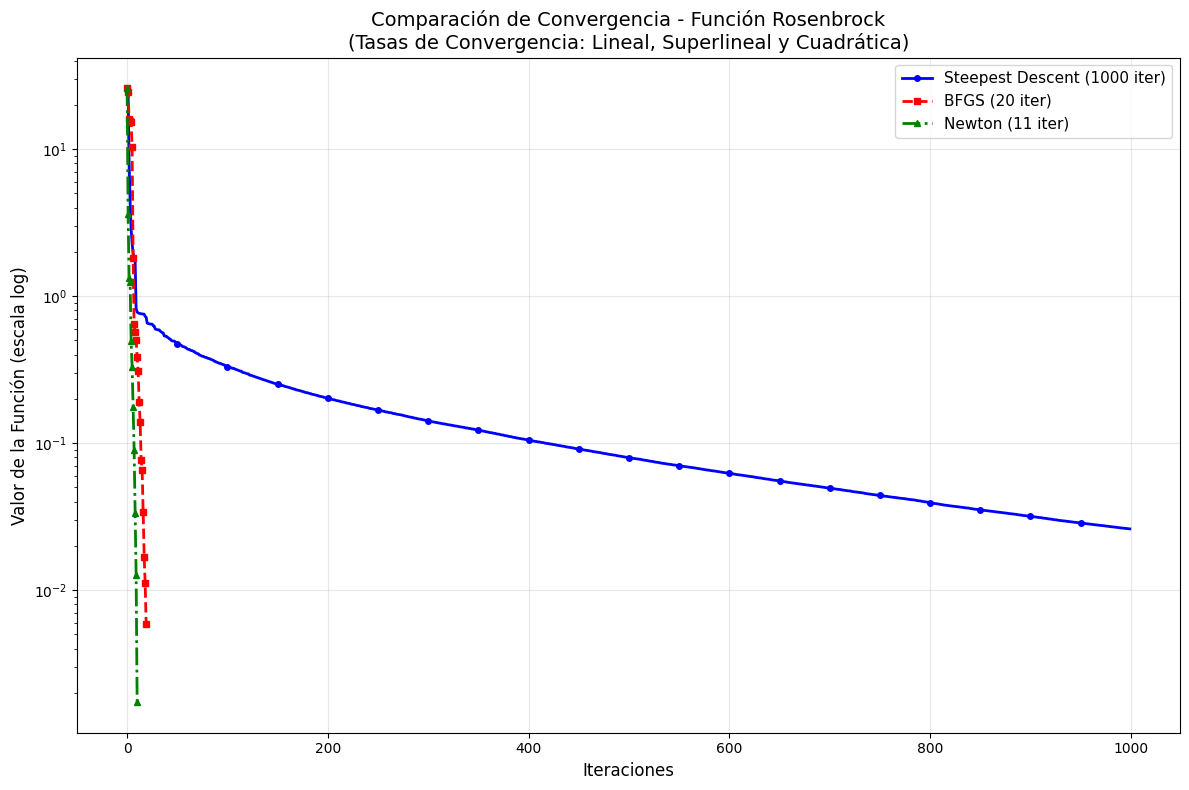

In [18]:
# Crear figura comparativa de convergencia
plt.figure(figsize=(12, 8))

# Determinar el número máximo de iteraciones para normalizar la comparación
max_iter = max(len(traj) for traj in trajectories)

# Graficar cada método
colors = ['blue', 'red', 'green']
markers = ['o', 's', '^']
linestyles = ['-', '--', '-.']

for i, (alg, traj) in enumerate(zip(algorithms, trajectories)):
    iterations = range(len(traj))
    plt.semilogy(iterations, traj, 
                color=colors[i], 
                marker=markers[i], 
                linestyle=linestyles[i],
                markersize=4,
                linewidth=2,
                label=f'{alg} ({len(traj)} iter)',
                markevery=max(1, len(traj)//20))  # Mostrar marcadores cada cierto número de puntos

plt.xlabel('Iteraciones', fontsize=12)
plt.ylabel('Valor de la Función (escala log)', fontsize=12)
plt.title('Comparación de Convergencia - Función Rosenbrock\n(Tasas de Convergencia: Lineal, Superlineal y Cuadrática)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Problema 7

Considere el "Linear" dataset $D=\{X, y\}$ proporcionado con esta tarea. Considere un modelo con la siguiente forma
\begin{align} \tag{7}
h(X;\theta) = \sum_{j=0}^{N} \theta_j\, x^{j}.
\end{align}

Encuentre los parámetros óptimos de (7) considerando $N=1$ usando las ecuaciones normales. Realice una gráfica del modelo y de los datos. ¿Cuál es el error que obtiene con los parámetros encontrados?

## Métodos

In [19]:
import numpy as np                  # Para operaciones vectoriales y matriciales
import pandas as pd                 # Para uso de tablas
import matplotlib.pyplot as plt     # Para visualización de datos  

In [20]:
class LeastSquares:
    def __init__(self):
        # Parametros del modelo
        self.theta = None
        self.X_train = None
        self.y_train = None
    
    def load_data(self, csv_path: str):
        # Cargar datos desde un archivo CSV
        data = pd.read_csv(csv_path)
        return data['X'].values, data['y'].values
    
    def fit(self, X: np.ndarray, y: np.ndarray):
        ''' 
        Ajuste del modelo de mínimos cuadrados

        Args:
            X (np.ndarray): Datos de entrada (características).
            y (np.ndarray): Datos de salida (objetivo).

        Returns:
            None, solo actualiza los parámetros del modelo.
        '''

        self.X_train = X.copy()
        self.y_train = y.copy()

        X_design = np.column_stack([np.ones(len(X)), X])

        # Cálculo de los parámetros usando la fórmula cerrada
        self.theta = np.linalg.inv(X_design.T.dot(X_design)).dot(X_design.T).dot(y)
    
    def predict(self, X: np.ndarray):
        # Realiza predicciones usando el modelo ajustado
        return self.theta[0] + self.theta[1] * X
    
    def error(self):
        # Calcula el error cuadrático medio en los datos de entrenamiento
        predictions = self.predict(self.X_train)
        return np.mean((self.y_train - predictions) ** 2)
    
    def plot(self):
        ''' 
        Plotea los datos y la línea de regresión ajustada.

        Args:
            None, usa los datos almacenados en la instancia.

        Returns:
            None, solo muestra la gráfica.
        '''
        plt.figure(figsize=(8, 6))
        plt.scatter(self.X_train, self.y_train, alpha=0.6, label='Datos')
        
        X_line = np.linspace(self.X_train.min(), self.X_train.max(), 100)
        y_line = self.predict(X_line)
        plt.plot(X_line, y_line, 'r-', label='Modelo')
        
        plt.xlabel('X')
        plt.ylabel('y')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()


## Resultados

Parámetros ajustados (θ): [ 9.79628653 -1.15631734]
Error cuadrático medio: 1.1421433790256026


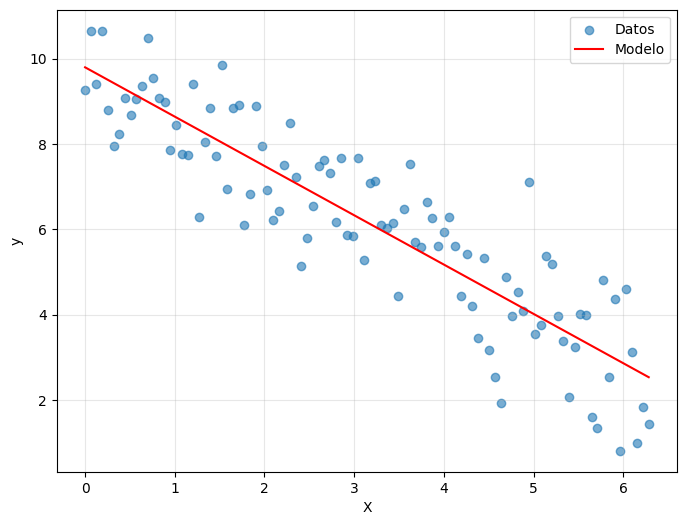

In [21]:
# Inicializacion de la instancia de la clase LeastSquares
model = LeastSquares()

# Carga de datos
X, y = model.load_data('Linear.csv')

# Ajuste del modelo
model.fit(X, y)

# Resultados
print("Parámetros ajustados (θ):", model.theta)
print("Error cuadrático medio:", model.error())
model.plot()

# Problema 8

Considere el "Polynomial" dataset $D = \{X,y\}$ proporcionado con esta tarea. Considere un modelo con la forma (7). Utilizando las ecuaciones normales, encuentre los parámetros óptimos del modelo probando varios valores de $N$. Genere gráficos del modelo y los datos para respaldar sus estimaciones de $N$. ¿Cuál es el error que obtiene con los parámetros que encontró para cada valor de $N$ probado? ¿Cuál es el valor óptimo de $N$ según su análisis?

## Métodos

In [22]:
import numpy as np              # Para operaciones vectoriales y matriciales
import pandas as pd             # Para uso de tablas       
import matplotlib.pyplot as plt # Para visualización de datos

In [23]:
class PolynomialLeastSquares:
    def __init__(self):
        # Parametros del modelo
        self.theta = None
        self.X_train = None
        self.y_train = None
        self.N = None
    
    def load_data(self, csv_path: str):
        # Cargar datos desde un archivo CSV
        data = pd.read_csv(csv_path)
        return data['X'].values, data['y'].values
    
    def fit(self, X: np.ndarray, y: np.ndarray, N: int):
        '''
        Ajuste del modelo de mínimos cuadrados polinomial

        Args:
            X (np.ndarray): Datos de entrada (características).
            y (np.ndarray): Datos de salida (objetivo).
            N (int): Grado del polinomio.

        Returns:
            None, solo actualiza los parámetros del modelo.
        '''
        self.X_train = X.copy()
        self.y_train = y.copy()
        self.N = N

        # Construcción de la matriz de diseño para un polinomio de grado N
        X_design = np.zeros((len(X), N + 1))
        for j in range(N + 1):
            X_design[:, j] = X ** j

        # Calculo de los parametros usando la formula cerrada
        self.theta = np.linalg.solve(X_design.T @ X_design, X_design.T @ y)
    
    def predict(self, X: np.ndarray):
        # Realiza predicciones usando el modelo ajustado
        result = np.zeros_like(X)
        for j in range(self.N + 1):
            result += self.theta[j] * (X ** j)
        return result
    
    def error(self):
        # Calcula el error cuadrático medio en los datos de entrenamiento
        predictions = self.predict(self.X_train)
        return np.mean((self.y_train - predictions) ** 2)
    
    def plot(self, title_suffix=""):
        '''
        Plotea los datos y la curva de regresión polinomial ajustada.

        Args:
            title_suffix (str): Sufijo para el título del gráfico.
            
        Returns:
            None, solo muestra la gráfica.
        '''
        plt.figure(figsize=(8, 6))
        plt.scatter(self.X_train, self.y_train, alpha=0.7, label='Datos', color='blue')
        
        X_line = np.linspace(self.X_train.min(), self.X_train.max(), 200)
        y_line = self.predict(X_line)
        plt.plot(X_line, y_line, 'r-', linewidth=2, label=f'Polinomio N={self.N}')
        
        plt.xlabel('X')
        plt.ylabel('y')
        plt.title(f'Regresión Polinomial N={self.N} - MSE: {self.error():.4f}{title_suffix}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()


## Resultados

In [24]:
# Inicializacion de la instancia de la clase PolynomialLeastSquares
model = PolynomialLeastSquares()

# Carga de datos
X, y = model.load_data('Polynomial.csv')

Parámetros ajustados (θ): [ 0.80206395 -0.16349188 -1.57140715]
Error cuadrático medio: 2.224135277083293


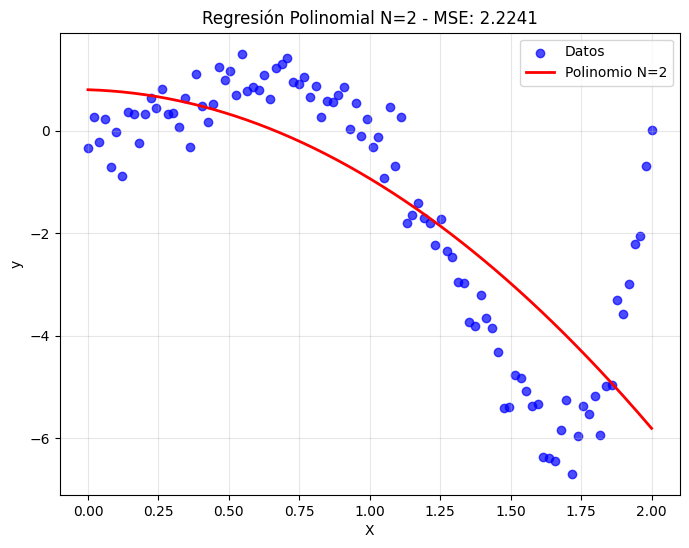

In [25]:
# Ajuste del modelo con polinomio de grado N=2
model.fit(X, y, N=2)
print("Parámetros ajustados (θ):", model.theta)
print("Error cuadrático medio:", model.error())
model.plot()

Parámetros ajustados (θ): [ -1.98977085  17.02071243 -23.15996141   7.19618475]
Error cuadrático medio: 0.968662907099181


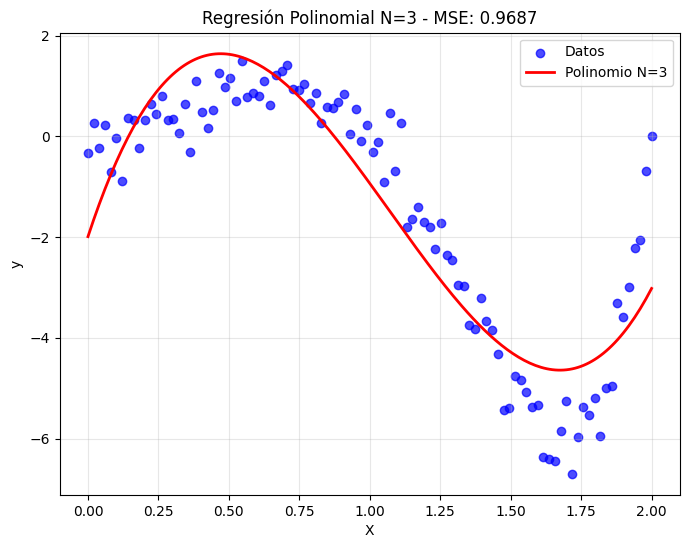

In [26]:
# Ajuste del modelo con polinomio de grado N=3
model.fit(X, y, N=3)
print("Parámetros ajustados (θ):", model.theta)
print("Error cuadrático medio:", model.error())
model.plot()

Parámetros ajustados (θ): [ -0.1814891    0.41430346   8.20039693 -12.27702137   7.3595365
  -5.37202314   1.85993366]
Error cuadrático medio: 0.15658267719533484


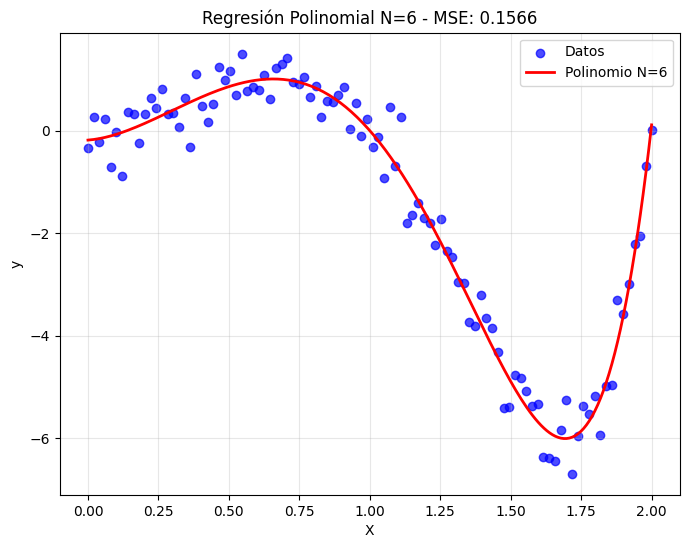

In [27]:
# Ajuste del modelo con polinomio de grado N=6
model.fit(X, y, N=6)
print("Parámetros ajustados (θ):", model.theta)
print("Error cuadrático medio:", model.error())
model.plot()

# Problema 9

Considere el "Lennard-Jones energy levels" dataset proporcionado con esta tarea. Dadas $N$ partículas, $N \ge 2$, la energía potencial de Lennard Jones está dada por

\begin{align} \tag{8}
    E_N &= 4 \sum_{i<j}^{N} \left[ \left(\frac{1}{r_{ij}}\right)^{12} - \left(\frac{1}{r_{ij}}\right)^{6} \right],
\end{align}

Donde $r_{ij}$ denota la distancia euclidiana entre las partículas $X_i$ y $X_j$. Para diversas aplicaciones, resulta de gran interés encontrar la configuración espacial particular de $N$ partículas que minimice la energía (8). Entonces:

a. Elija un valor particular para $N$ mayor que 2.

b. Escriba la expresión para el vector residual $r(X)$.

c. Usando los datos proporcionados, implemente el método de Gauss-Newton para resolver el problema de mínimos cuadrados no lineales.

d. Grafique los valores de (8) a lo largo de las iteraciones y compare su estimación final con los de la Tabla 1 de \cite{wales1997}.

e. Grafique en 3D la configuración final de la partícula (es decir, los puntos $X$).

f. ¿Cuál fue el valor máximo de $N$ que pudo obtener?


## Métodos

In [ ]:
import numpy as np                      # Para operaciones vectoriales y matriciales
import matplotlib.pyplot as plt         # Para visualización de datos
from mpl_toolkits.mplot3d import Axes3D # Para gráficos 3D
import pandas as pd                     # Para manejo de datos tabulares
from typing import Callable             # Para anotaciones de tipos

In [29]:
class GaussNewton:
    def __init__(self):
        # Historial de energía y posiciones
        self.energy_history = []
        self.positions_history = []
        
    def optimize(self, 
                 initial_positions: np.ndarray, 
                 residual_func: Callable, 
                 jacobian_func: Callable, 
                 energy_func: Callable, 
                 max_iter: int = 100, 
                 tol: float = 1e-6):
        ''' 
        Optimización utilizando el método de Gauss-Newton.

        Args:
            initial_positions (np.ndarray): Posiciones iniciales de las partículas.
            residual_func (Callable): Función que calcula el vector de residuos.
            jacobian_func (Callable): Función que calcula la matriz Jacobiana.
            energy_func (Callable): Función que calcula la energía total del sistema.
            max_iter (int): Número máximo de iteraciones.
            tol (float): Tolerancia para el criterio de convergencia.

        Returns:
            positions (np.ndarray): Posiciones optimizadas de las partículas.
            energy (float): Energía mínima alcanzada.
        '''

        positions = initial_positions.copy()
        self.energy_history = []
        self.positions_history = []
        
        for iteration in range(max_iter):
            # Calcular energía actual
            energy = energy_func(positions)
            self.energy_history.append(energy)
            self.positions_history.append(positions.copy())
            
            # Calcular residual y jacobiano
            residual = residual_func(positions)
            jacobian = jacobian_func(positions)
            
            # Verificar convergencia
            if np.linalg.norm(residual) < tol:
                print(f"Convergió en {iteration} iteraciones")
                break
            
            # Paso de Gauss-Newton: J^T J delta = -J^T r

            JTJ = jacobian.T @ jacobian
            JTr = jacobian.T @ residual
            
            # Regularización para estabilidad numérica
            reg = 1e-8 * np.eye(JTJ.shape[0])
            delta = np.linalg.solve(JTJ + reg, -JTr)
            
            # Actualizar posiciones
            delta_reshaped = delta.reshape(positions.shape)
            
            # Line search simple
            alpha = 1.0
            new_positions = positions + alpha * delta_reshaped
            new_energy = energy_func(new_positions)
            
            # Reducir alpha si la energía aumenta
            while new_energy > energy and alpha > 1e-4:
                alpha *= 0.5
                new_positions = positions + alpha * delta_reshaped
                new_energy = energy_func(new_positions)
            
            positions = new_positions
                
        
        return positions, energy
    
    def plot_energy_convergence(self):
        """
        Gráfica la convergencia de la funcion de energia.

        Args:
            None, usa los datos almacenados en la instancia.

        Returns:
            None, solo muestra la gráfica.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(self.energy_history, 'b-', linewidth=2)
        plt.xlabel('Iteración')
        plt.ylabel('Energía de Lennard-Jones')
        plt.title('Convergencia de la Energía')
        plt.grid(True)
        plt.show()
    
    def plot_final_configuration(self, final_positions):
        """
        Gráfica la configuración final en 3D.

        Args:
            final_positions (np.ndarray): Posiciones finales de las partículas.

        Returns:
            None, solo muestra la gráfica.
        """
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        # Plotear partículas
        ax.scatter(final_positions[:, 0], final_positions[:, 1], final_positions[:, 2], 
                  c='red', s=100, alpha=0.8)
        
        # Conectar partículas cercanas con líneas
        N = final_positions.shape[0]
        for i in range(N):
            for j in range(i+1, N):
                dist = np.linalg.norm(final_positions[i] - final_positions[j])
                if dist < 2.0:  # Solo conectar partículas cercanas
                    ax.plot([final_positions[i, 0], final_positions[j, 0]],
                           [final_positions[i, 1], final_positions[j, 1]],
                           [final_positions[i, 2], final_positions[j, 2]], 
                           'k-', alpha=0.3)
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y') 
        ax.set_zlabel('Z')
        ax.set_title(f'Configuración Final - {N} Partículas')
        plt.show()


In [30]:
# Funcion de Lennard-Jones
def lennard_jones_energy(positions):
    N = positions.shape[0]
    energy = 0.0
    
    for i in range(N):
        for j in range(i+1, N):
            r_ij = np.linalg.norm(positions[i] - positions[j])
            if r_ij > 1e-10:  # Evitar división por cero
                r_inv = 1.0 / r_ij
                energy += 4 * (r_inv**12 - r_inv**6)
    
    return energy

# Funciones de residual de Lennard-Jones
def lennard_jones_residual(positions):
    N = positions.shape[0]
    gradient = np.zeros_like(positions)
    
    for i in range(N):
        for j in range(N):
            if i != j:
                r_vec = positions[i] - positions[j]
                r_ij = np.linalg.norm(r_vec)
                if r_ij > 1e-10:
                    r_inv = 1.0 / r_ij
                    factor = 4 * (-12 * r_inv**14 + 6 * r_inv**8)
                    gradient[i] += factor * r_vec
    
    return gradient.flatten()


# Función Jacobiana de Lennard-Jones
def lennard_jones_jacobian(positions):
    N = positions.shape[0]
    dim = 3 * N
    jacobian = np.zeros((dim, dim))
    
    for i in range(N):
        for j in range(N):
            if i != j:
                r_vec = positions[i] - positions[j]
                r_ij = np.linalg.norm(r_vec)
                if r_ij > 1e-10:
                    r_inv = 1.0 / r_ij
                    
                    # Términos de la segunda derivada
                    factor1 = 4 * (-12 * r_inv**14 + 6 * r_inv**8)
                    factor2 = 4 * (168 * r_inv**16 - 48 * r_inv**10)
                    
                    # Matriz identidad por factor1
                    for k in range(3):
                        jacobian[3*i + k, 3*i + k] += factor1
                    
                    # Término de producto exterior
                    outer = np.outer(r_vec, r_vec) * factor2
                    for k in range(3):
                        for l in range(3):
                            jacobian[3*i + k, 3*i + l] += outer[k, l]
    
    return jacobian

## Resultados

Optimizando para N = 25 partículas
Energía final calculada: -8.144309
Energía de referencia: -102.372663
Error: 94.228354


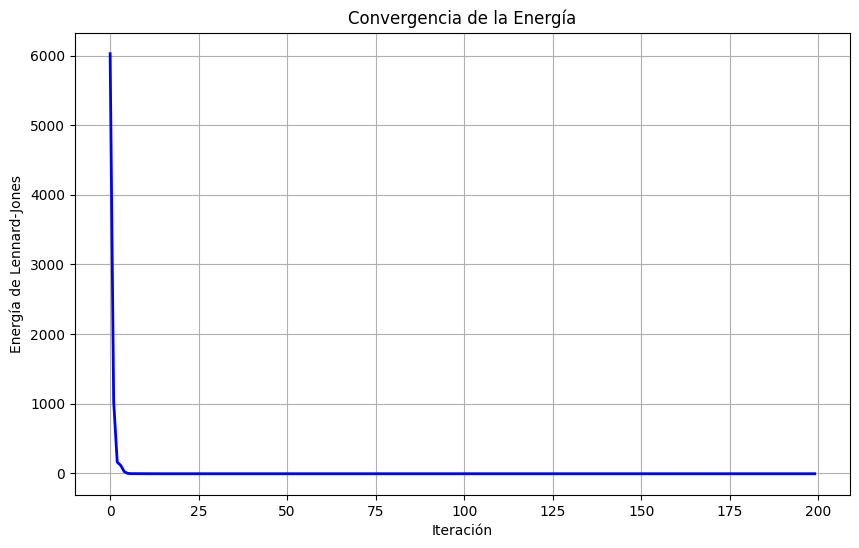

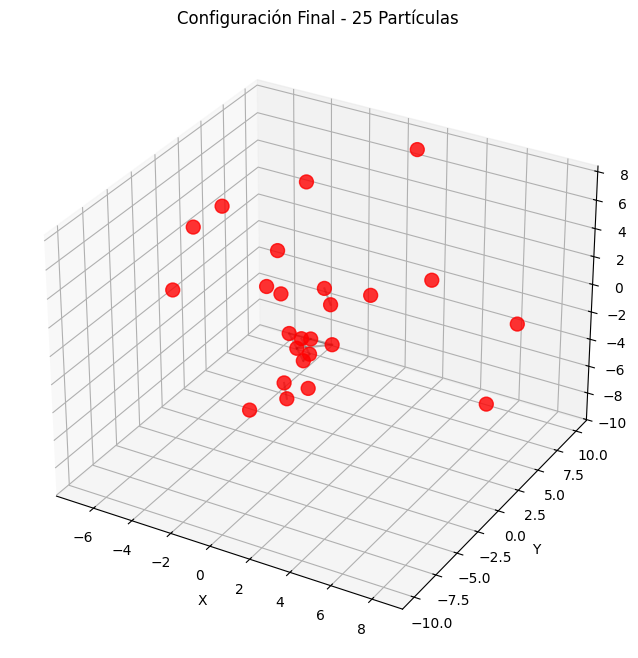

In [31]:
# Cargar datos de referencia
df = pd.read_csv('Lennard-Jones energy levels.csv')
reference_data = dict(zip(df['N'], df['Energy']))

# Seleccionamos un N>=2
N = 25
np.random.seed(42)

# Posiciones iniciales aleatorias
initial_positions = np.random.randn(N, 3) * 2.0

# Instancia del optimizador Gauss-Newton
optimizer = GaussNewton()

print(f"Optimizando para N = {N} partículas")
final_positions, final_energy = optimizer.optimize(
    initial_positions, 
    lennard_jones_residual, 
    lennard_jones_jacobian, 
    lennard_jones_energy,
    max_iter=200,
    tol=1e-6
)

print(f"Energía final calculada: {final_energy:.6f}")

# Comparar con datos de referencia
ref_energy = reference_data[N]
error = abs(final_energy - ref_energy)
print(f"Energía de referencia: {ref_energy:.6f}")
print(f"Error: {error:.6f}")

# Graficar resultados
optimizer.plot_energy_convergence()
optimizer.plot_final_configuration(final_positions)